## Import Package

In [2]:
import matplotlib.pyplot as plt
from scipy.io import wavfile
import librosa
import glob
import os
import librosa.display
import numpy as np
import matplotlib.pyplot as plt
import librosa as li
import numpy as np 
from sklearn.cluster import AffinityPropagation, KMeans
from scipy import stats
from IPython.display import Audio
from matplotlib.pyplot import specgram
import sklearn
%matplotlib inline



## Load audio file

In [3]:
file_name = "./data/1.wav"
audio_time_series, sample_rate = li.load(file_name)
Audio(audio_time_series, rate=sample_rate)

## Plot Audio

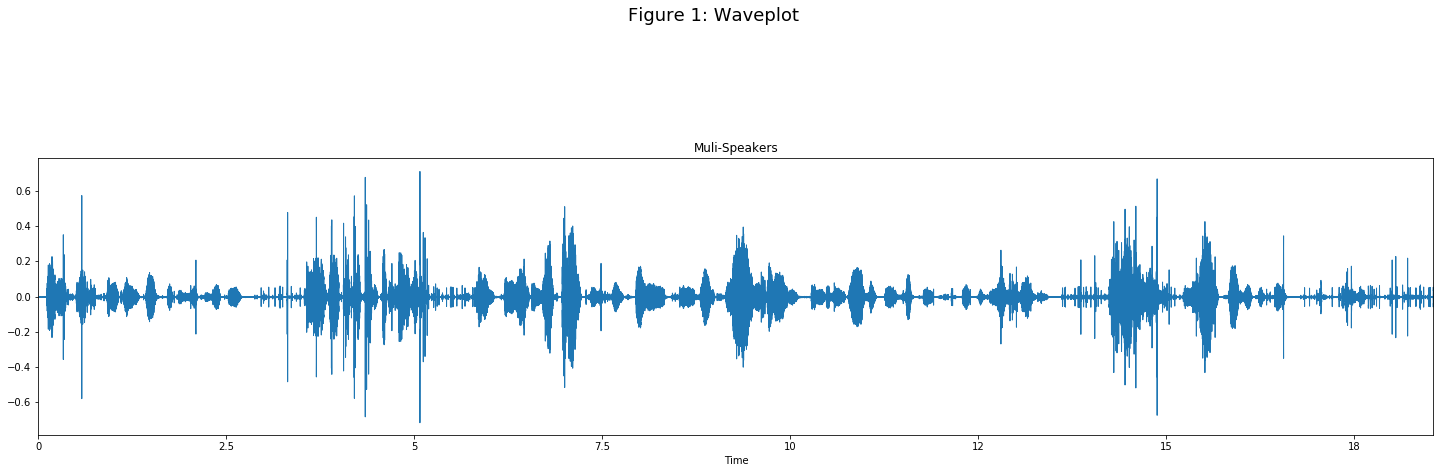

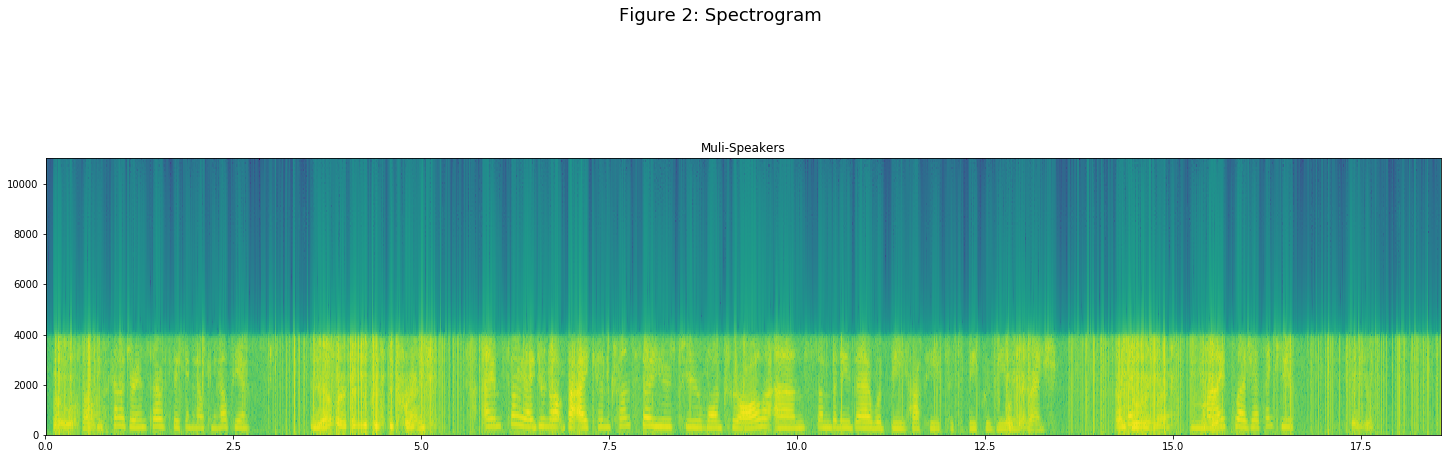

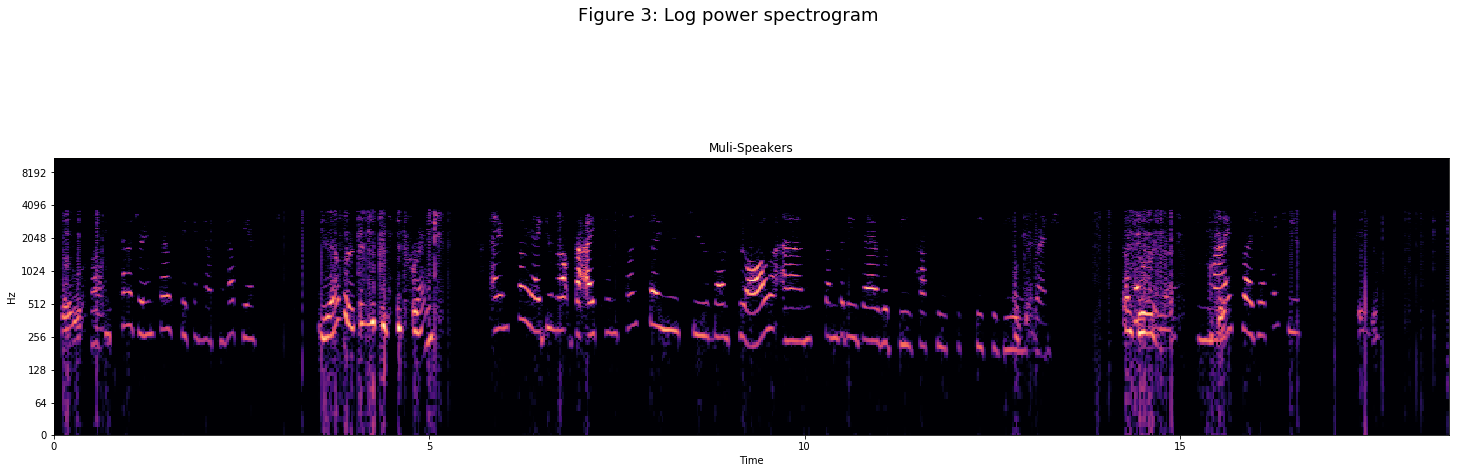

In [4]:
def load_sound_files(file_paths):
    raw_sounds = []
    for fp in file_paths:
        X,sr = librosa.load(fp)
        raw_sounds.append(X)
    return raw_sounds

def plot_waves(sound_names,raw_sounds):
    i = 1
    #fig = plt.figure(figsize=(25,60), dpi = 900)
    fig = plt.figure(figsize=(25,60))
    for n,f in zip(sound_names,raw_sounds):
        plt.subplot(10,1,i)
        librosa.display.waveplot(np.array(f),sr=22050)
        plt.title(n.title())
        i += 1
    plt.suptitle("Figure 1: Waveplot",x=0.5, y=0.915,fontsize=18)
    plt.show()

def plot_specgram(sound_names,raw_sounds):
    i = 1
    #fig = plt.figure(figsize=(25,60), dpi = 900)
    fig = plt.figure(figsize=(25,60))
    for n,f in zip(sound_names,raw_sounds):
        plt.subplot(10,1,i)
        specgram(np.array(f), Fs=22050)
        plt.title(n.title())
        i += 1
    plt.suptitle("Figure 2: Spectrogram",x=0.5, y=0.915,fontsize=18)
    plt.show()

def plot_log_power_specgram(sound_names,raw_sounds):
    i = 1
    #fig = plt.figure(figsize=(25,60), dpi = 900)
    fig = plt.figure(figsize=(25,60))
    for n,f in zip(sound_names,raw_sounds):
        plt.subplot(10,1,i)
        #D = librosa.logamplitude(np.abs(librosa.stft(f))**2, ref_power=np.max)
        D = librosa.core.amplitude_to_db(np.abs(librosa.stft(f))**2, ref=np.max)
        librosa.display.specshow(D,x_axis='time' ,y_axis='log')
        plt.title(n.title())
        i += 1
    plt.suptitle("Figure 3: Log power spectrogram",x=0.5, y=0.915,fontsize=18)
    plt.show()


sound_file_paths = [file_name]

sound_names = ["muli-speakers"]

raw_sounds = load_sound_files(sound_file_paths)

plot_waves(sound_names,raw_sounds)
plot_specgram(sound_names,raw_sounds)
plot_log_power_specgram(sound_names,raw_sounds)

In [38]:
length_series = len(audio_time_series)
#print(length_series)

zero_crossings = []
energy = []
entropy_of_energy = []
mfcc = []
mfdd = []
chroma_stft = []
for i in range(0,length_series,int(sample_rate/5.0)):
    frame_self = audio_time_series[i:i+int(sample_rate/5.0):1]
    z = li.zero_crossings(frame_self)
    arr = np.nonzero(z)
    zero_crossings.append(len(arr[0]))
    e = li.feature.rmse(frame_self)
    energy.append(np.mean(e))
    ent = 0.0
    m = np.mean(e)
    for j in range(0,len(e[0])):
        q = np.absolute(e[0][j] - m)
        ent = ent + (q * np.log10(q))
    entropy_of_energy.append(ent)
    mt = []
    mf = li.feature.mfcc(frame_self,n_mfcc=13)
    mf=mf[0:-1]
    ##mfcc scaling
    mf = sklearn.preprocessing.scale(mf, axis=1)
    D = librosa.core.amplitude_to_db(np.abs(librosa.stft(frame_self))**2, ref=np.max)
    md = []
    for k in range(0,len(mf)):
        mt.append(np.mean(mf[k]))
    mfcc.append(mt)
    for h in range(0,len(D)):
        md.append(np.mean(D[k]))
    mfdd.append(md)
    ct = []
    cf = li.feature.chroma_stft(frame_self)
    for k in range(0,len(cf)):
        ct.append(np.mean(cf[k]))
    chroma_stft.append(ct)
    #print(i)
f_list_1 = []
f_list_1.append(zero_crossings)
f_list_1.append(energy)
f_list_1.append(entropy_of_energy)
f_np_1 = np.array(f_list_1)
f_np_1 = np.transpose(f_np_1)

sp_centroid = []
sp_bandwidth = []
sp_contrast = []
sp_rolloff = []
for i in range(0,length_series,int(sample_rate/5.0)):
    frame_self = audio_time_series[i:i+int(sample_rate/5.0):1]
    cp = li.feature.spectral_centroid(y=frame_self, hop_length=220500)
    sp_centroid.append(cp[0][0])
    bp = li.feature.spectral_bandwidth(y=frame_self, hop_length=220500)
    sp_bandwidth.append(bp[0][0])
    csp = li.feature.spectral_contrast(y=frame_self, hop_length=220500)
    sp_contrast.append(np.mean(csp))
    rsp = li.feature.spectral_rolloff(y=frame_self, hop_length=220500)
    sp_rolloff.append(np.mean(rsp[0][0]))
    #print(i)

f_list_2 = []
f_list_2.append(sp_centroid)
f_list_2.append(sp_bandwidth)
f_list_2.append(sp_contrast)
f_list_2.append(sp_rolloff)
f_np_2 = np.array(f_list_2)
f_np_2 = np.transpose(f_np_2)

f_np_3 = np.array(mfcc)
f_np_4 = np.array(chroma_stft)
f_np_5 = np.array(mfdd)

#master = np.concatenate([f_np_1, f_np_2, f_np_3,f_np_4], axis=1)
master = np.concatenate([f_np_3,f_np_4,f_np_5], axis=1)

#kmeans

cluster_obj = KMeans(n_clusters = 2 ,random_state=0).fit(master)
res = cluster_obj.predict(master)
#GMM
#gmm = GMM(n_components=4).fit(master)
#res = gmm.predict(master)

s = res[0]
t=0.0
time = []
speaker = []
time.append(t)
speaker.append(s)
for u in range(0, len(res), 1):
    if(res[u]==s):
        t=t+0.2
    else:
        t=t+0.2
        s=res[u]
        speaker.append(s)
        time.append(t)

#print(time)
#print(speaker)
speakerN = speaker
speakerN.append(0)
for i in range(2, len(time)):
    if((time[i]-time[i-1]) >0.5):
        pass
    else:
        speaker[i-1] = speakerN[i-2]     

fin = []

for i in range(1,len(time)):
    if(speaker[i]!=speaker[i-1]):
        fin.append([time[i-1], speaker[i-1]])
    else:
        pass

for p in range(0, len(fin)):
    print("TIME : " + str(fin[p][0]) + " ---- " + "SPEAKER : " + str(fin[p][1]))

TIME : 3.600000000000001 ---- SPEAKER : 0
TIME : 5.400000000000002 ---- SPEAKER : 1
TIME : 6.000000000000003 ---- SPEAKER : 0
TIME : 13.799999999999983 ---- SPEAKER : 1
TIME : 15.399999999999977 ---- SPEAKER : 0


## Plot Kmeans speaker diarization

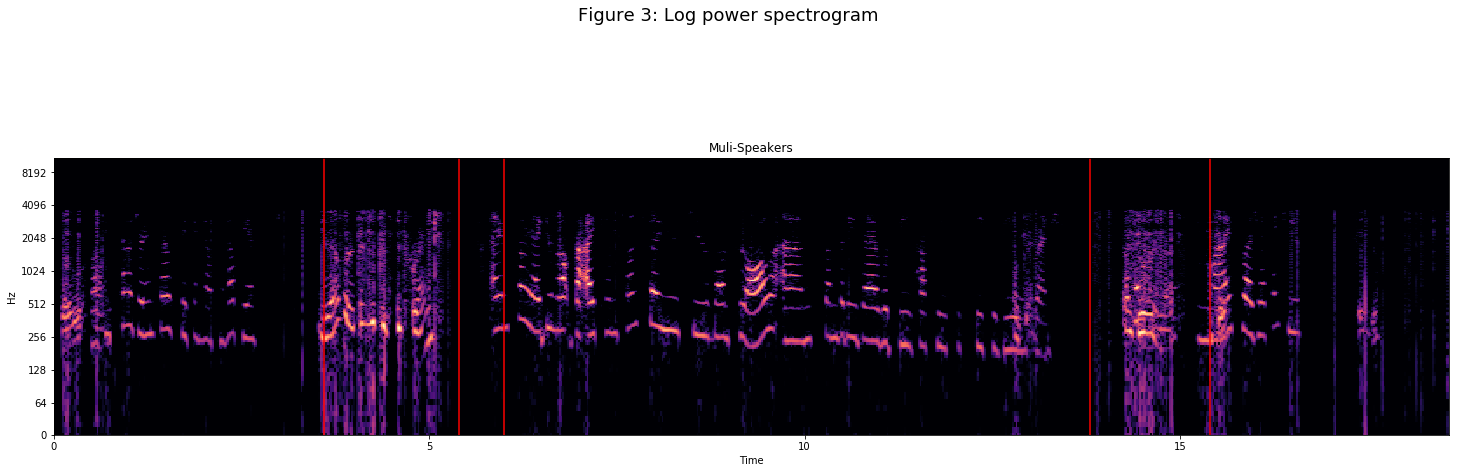

In [39]:

i = 1
#fig = plt.figure(figsize=(25,60), dpi = 900)
fig = plt.figure(figsize=(25,60))
for n,f in zip(sound_names,raw_sounds):
    plt.subplot(10,1,i)
    #D = librosa.logamplitude(np.abs(librosa.stft(f))**2, ref_power=np.max)
    D = librosa.core.amplitude_to_db(np.abs(librosa.stft(f))**2, ref=np.max)
    librosa.display.specshow(D,x_axis='time' ,y_axis='log')
    plt.title(n.title())
    i += 1

for i in range(len(fin)):
    #plt.axvline(x=time[i], c='r')
    plt.axvline(x=fin[i][0], c='r')

plt.suptitle("Figure 3: Log power spectrogram",x=0.5, y=0.915,fontsize=18)
plt.show()

In [37]:
mf.shape

(11, 7)